In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

SEED = 1234

# 1. Cargar y preparar los datos
datos = pd.read_csv("data\Temp_Asu20092021.csv")

# Convertir 'Fecha' a tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019
datos = datos[datos.index.year >= 2019]

# Eliminar valores faltantes
datos.dropna(inplace=True)

# Calcular percentiles diarios (95, 50, 5)

percentiles_diarios = datos.resample('D')['Temperatura'].agg(
    Percentil_95=lambda x: np.percentile(x, 95),
    Mediana=lambda x: np.percentile(x, 50),
    Percentil_5=lambda x: np.percentile(x, 5)
)


# Crear las variables objetivo para el día siguiente
percentiles_diarios['Percentil_95_next'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_next'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_next'] = percentiles_diarios['Percentil_5'].shift(-1)

# Eliminar filas con valores faltantes después del desplazamiento
percentiles_diarios.dropna(inplace=True)

# Definir variables predictoras (X) y objetivo (y)
X = percentiles_diarios[[ 'Mediana']]
y = percentiles_diarios[[ 'Mediana_next']]

# 2. Dividir en conjuntos de entrenamiento y validación
split_index = int(len(X) * 0.8)
X_train, X_valid = X.iloc[:split_index].values, X.iloc[split_index:].values
y_train, y_valid = y.iloc[:split_index].values, y.iloc[split_index:].values

# 3. Definir la función objetivo para la optimización con Optuna
def objective(trial):
    # Sugerir hiperparámetros
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)

    # Entrenar un modelo ARIMA para cada serie objetivo
    mae_scores = []

    try:
        # Ajustar modelo ARIMA
        model = ARIMA(X_train, order=(p, d, q))
        model_fit = model.fit()

        # Predecir en conjunto de validación
        y_pred = model_fit.forecast(steps=len(X_valid))
        mae = mean_absolute_error(X_valid, y_pred)
        mae_scores.append(mae)

    except Exception as e:
        # Si el modelo falla, retornar un MAE alto para que Optuna descarte la configuración
        print(f"Error en la iteración: {e}")
        return float('inf')

    return np.mean(mae_scores)

# 4. Optimización con Optuna
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=SEED))
study.optimize(objective, n_trials=50)

# 5. Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
print("Mejores Hiperparámetros:", best_params)


[I 2024-10-17 11:46:23,872] A new study created in memory with name: no-name-16d63cb9-32ac-491d-9221-463ac3920067
[I 2024-10-17 11:46:24,153] Trial 0 finished with value: 5.958444660294106 and parameters: {'p': 1, 'd': 1, 'q': 2}. Best is trial 0 with value: 5.958444660294106.
[I 2024-10-17 11:46:24,686] Trial 1 finished with value: 8.90947880227487 and parameters: {'p': 4, 'd': 2, 'q': 1}. Best is trial 0 with value: 5.958444660294106.
h:\Anaconda\envs\IA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
h:\Anaconda\envs\IA\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-10-17 11:46:25,581] Trial 2 finished with value: 20.035773153403692 and parameters: {'p': 1, 'd': 2, '

Mejores Hiperparámetros: {'p': 3, 'd': 0, 'q': 2}


MAE promedio en validación: 4.519007266905449


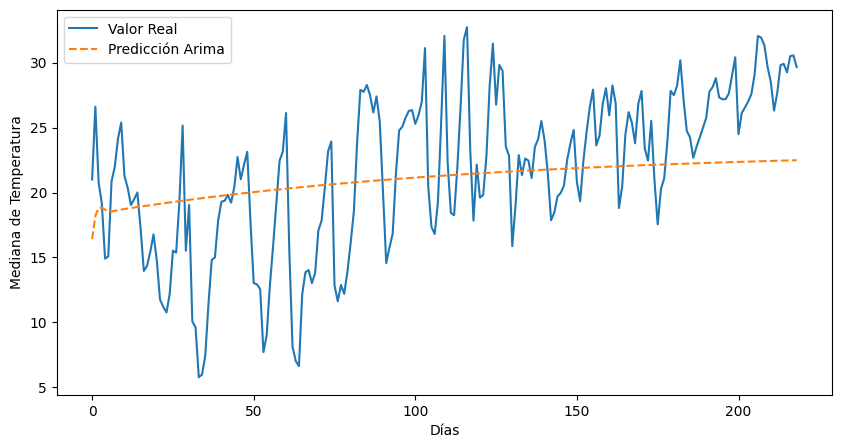

In [2]:

# Evaluación usando el mejor modelo encontrado
mae_scores_final = []
model = ARIMA(X_train, order=(best_params['p'], best_params['d'], best_params['q']))
model_fit = model.fit()

#y_pred = model_fit.forecast(steps=len(X_valid),dynamic =True)
predicciones = model_fit.predict(
    start=len(X-train), 
    end=len(X_train) + len(X_valid) - 1, 
)

# 11. Evaluar el modelo usando MAE y MSE
mae = mean_absolute_error(y_valid, predicciones)
print(f'MAE: {mae:.2f}')

# 12. Graficar las predicciones vs valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot( y_valid, label='Valor Real')
plt.plot( predicciones, label='Predicción Arima', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Mediana de Temperatura')
plt.legend()
plt.show()
mae = mean_absolute_error(y_valid, y_pred)
mae_scores_final.append(mae)

print(f"MAE promedio en validación: {np.mean(mae_scores_final)}")
plt.figure(figsize=(10, 5))
plt.plot(y_valid, label='Valor Real')
plt.plot(y_pred,label='Predicción Arima', linestyle='--')
plt.xlabel('Días')
plt.ylabel('Mediana de Temperatura')
plt.legend()
plt.show()

In [3]:
y_pred = model_fit.get_prediction(dynamic =True)
print(y_pred)